# Machine Learning Development Project: Submission 2
## Gold price forecasting
- Nama: Nabila Jauza Firjatullah
- Email: nabila060695@gmail.com
- Id Dicoding: billa_firza

#### Link to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install Library

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

#### EDA

In [3]:
df = pd.read_csv('/content/drive/MyDrive/IDCamp2023/Pengembangan ML/Gold Price/gold_price_data.csv')
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [4]:
df.isnull().sum()

Date     0
Value    0
dtype: int64

In [5]:
print(f"{df.duplicated().sum()}")

0


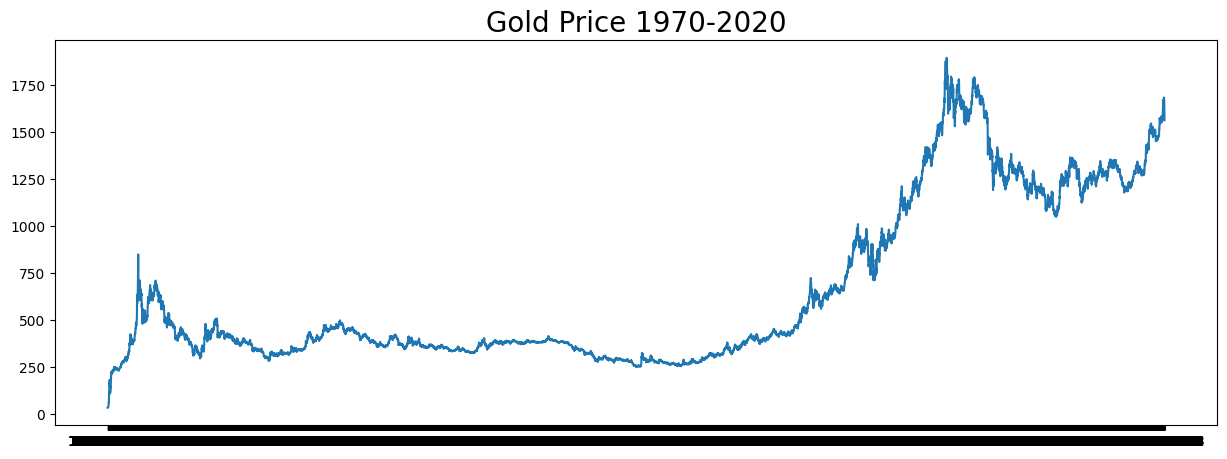

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Value'])
plt.title('Gold Price 1970-2020', fontsize=20);

#### Preprocessing Data

In [7]:
data = pd.DataFrame(list(df['Value']), index=df['Date'], columns=['Value'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10787 entries, 1970-01-01 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   10787 non-null  float64
dtypes: float64(1)
memory usage: 168.5+ KB


In [9]:
data.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [10]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled=scalar.fit_transform(data)

In [11]:
data['Value_Scaled']= data_scaled
data.head()

,Value,Value_Scaled
Date,,
1970-01-01,35.2,-0.999892
1970-04-01,35.1,-1.000000
1970-07-01,35.4,-0.999677
1970-10-01,36.2,-0.998817
1971-01-01,37.4,-0.997527


In [12]:
from sklearn.model_selection import train_test_split

X = data.index
y = data['Value_Scaled'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing:", X_test.shape[0])

Jumlah data training: 8629
Jumlah data testing: 2158


In [13]:
max_data_scale = data_scaled.max()
min_data_scale = data_scaled.min()
threshold_mae = (max_data_scale - min_data_scale) * 10/100
print("Max Value: ", max_data_scale)
print("Min Value: ", min_data_scale)
print("Threshold MAE: ", threshold_mae)

Max Value:  1.0
Min Value:  -1.0
Threshold MAE:  0.2


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
train_set = windowed_dataset(y_train, window_size=30, batch_size=32, shuffle_buffer=5000)
val_set = windowed_dataset(y_test, window_size=30, batch_size=32, shuffle_buffer=5000)

#### Model Train

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [18]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.2 and  logs.get('val_mae') < 0.2):
      print("\nMAE telah mencapai < 10% skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [20]:
history = model.fit(
  train_set,
  validation_data=val_set,
  epochs=100,
  batch_size=256,
  callbacks=[callbacks]
)

Epoch 1/100
269/269 [==============================] - 11s 13ms/step - loss: 0.0275 - mae: 0.1564 - val_loss: 0.0535 - val_mae: 0.3053
Epoch 2/100
265/269 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0393
MAE telah mencapai < 10% skala data!
269/269 [==============================] - 4s 12ms/step - loss: 0.0029 - mae: 0.0391 - val_loss: 0.0101 - val_mae: 0.0977


#### History Train Plot

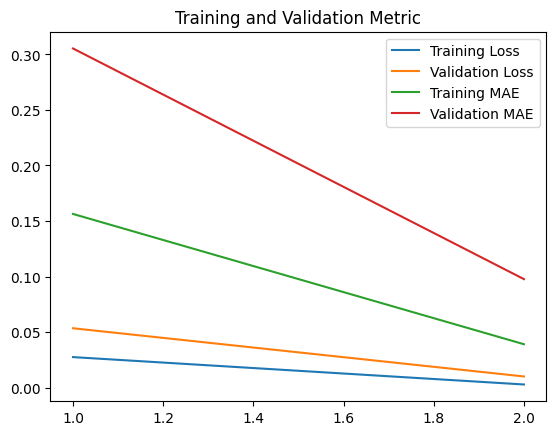

In [22]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots()

ax.plot(epochs, loss, label='Training Loss')
ax.plot(epochs, val_loss, label='Validation Loss')
ax.plot(epochs, mae, label='Training MAE')
ax.plot(epochs, val_mae, label='Validation MAE')

ax.set_title('Training and Validation Metric')
ax.legend()

plt.show()

#### Test Predict

In [23]:
window_size = 30

forecast = []

for time in range(len(y_test) - window_size):
    series_window = np.array([y_test[time:time + window_size]])

    series_window = series_window.reshape((series_window.shape[0], series_window.shape[1], 1))

    prediction = model.predict(series_window)

    forecast.append(prediction[0, 0])

1/1 [==============================] - 0s 18ms/step


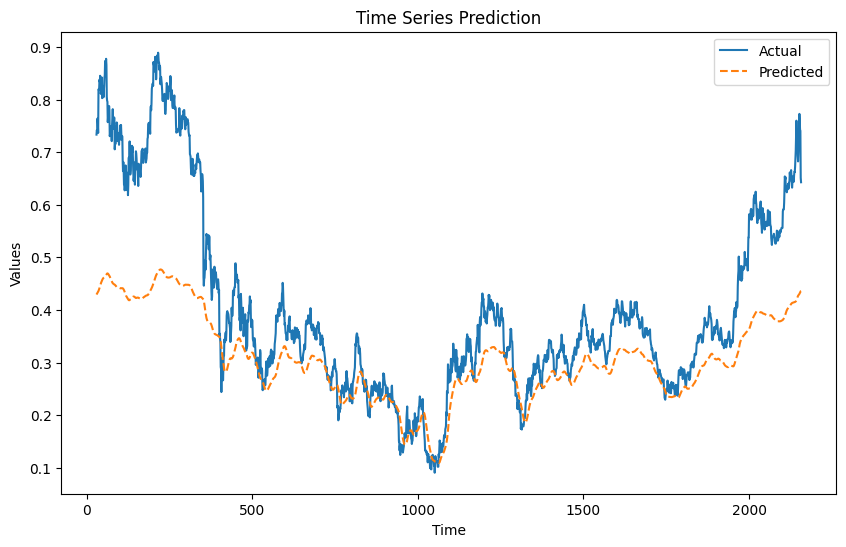

In [24]:
time_labels = np.arange(len(y_test))

plt.figure(figsize=(10, 6))

plt.plot(time_labels[window_size:], y_test[window_size:], label='Actual')

plt.plot(time_labels[window_size:], forecast, label='Predicted', linestyle='dashed')

plt.title('Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Values')

plt.legend()

plt.show()